<a href="https://colab.research.google.com/github/samarth2812/Creating-MNIST-Dataset-using-GAN/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

minst = MNIST(root ='data',
              train = True,
              download = True,
              transform= Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
img , label = minst[3]
print(' Label',label)
print(img[:,10:20,10:20])
torch.min(img), torch.max(img)

 Label 1
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.2157,  0.9843,
           0.9843,  0.4824, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -0.8431,  0.9843,  0.9686,
           0.8431, -0.4824, -1.0000],
         [-1.0000, -1.0000, -1.0000, -0.7490,  0.6078,  0.9843,  0.9686,
          -0.0118, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -0.1843,  0.9686,  0.9843,  0.4431,
          -0.8824, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.3725,  0.8824,  0.9686,  0.5137, -0.8196,
          -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.7490,  0.9843,  0.9843,  0.9843,  0.2471, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.1843,  0.9686,  0.9686,  0.9686, -0.6941, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.6235,  0.7333,  0.9686,  0.9686,  0.3490, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [ 0.8353,  0.9686,  0.9686,  0.5373, -0.9059, -1.0000, -1.0000,
          -1.0000, -1.0000, -1

(tensor(-1.), tensor(1.))

In [3]:
def denom(x):
  out = (x+1)/2
  return out.clamp(0,1)

Label 1


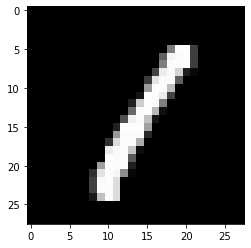

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_nom = denom(img)
plt.imshow(img_nom[0], cmap='gray')
print('Label',label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(minst, batch_size, shuffle = True)


In [6]:
for img_batch,label_batch in data_loader:
  print('first Batch')
  print(img_batch.shape)
  print(label_batch)
  break

first Batch
torch.Size([100, 1, 28, 28])
tensor([1, 1, 0, 6, 7, 4, 9, 5, 6, 4, 8, 2, 6, 2, 2, 9, 6, 1, 0, 8, 2, 1, 8, 2,
        6, 2, 6, 7, 9, 0, 9, 7, 2, 5, 3, 8, 3, 0, 0, 1, 3, 2, 1, 5, 5, 6, 7, 3,
        1, 3, 3, 3, 4, 9, 6, 3, 0, 0, 7, 3, 5, 4, 2, 9, 3, 7, 3, 9, 5, 7, 4, 1,
        5, 8, 7, 0, 5, 1, 0, 0, 3, 5, 2, 7, 7, 1, 5, 1, 9, 9, 0, 9, 0, 0, 7, 7,
        8, 1, 8, 0])


In [7]:
#Device Configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
image_size=784
hidden_size = 256

In [10]:
from torch.nn.modules.activation import LeakyReLU
import torch.nn as nn
D= nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()

)

In [11]:
D.to(device);

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size , image_size),
    nn.Tanh()


)

In [14]:
y= G(torch.randn(5, latent_size))
gen_imgs = denom(y.reshape((-1,28,28)).detach())

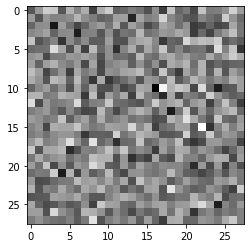

In [15]:
plt.imshow(gen_imgs[3], cmap='gray')

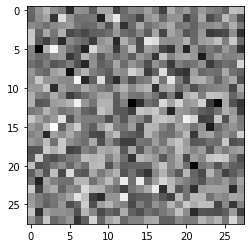

In [16]:
plt.imshow(gen_imgs[1], cmap='gray')

In [17]:
G.to(device);

In [18]:
criterion= nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr =0.0002)


In [20]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):

  #creating labels which will be used as inputs for BCE loss
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)
  
  #Loss for real images
  outputs = D(images)
  d_losss_real = criterion(outputs, real_labels)
  real_score = outputs

  #Loss for fake images
  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs,fake_labels)
  fake_score = outputs

  #combine loss
  d_loss = d_losss_real+ d_loss_fake

  #reset gradient
  reset_grad()

  #compute gradiants
  d_loss.backward()

  #adjust the parameters
  d_optimizer.step()
  return d_loss,real_score,fake_score

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [22]:
def train_generator():
  #generate fake images
  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size,1).to(device)
  g_loss = criterion(D(fake_images),labels)

  #optimize
  reset_grad()
  g_loss.backward()
  g_optimzer.step()
  return g_loss,fake_images

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

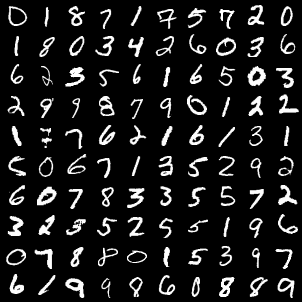

In [25]:
from IPython.display import Image
from torchvision.utils import save_image

#save some real images
for images, _ in data_loader:
  images = images.reshape(images.size(0),1,28,28)
  save_image(denom(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
  break
Image(os.path.join(sample_dir, 'real_images.png'))

In [30]:
sample_vector= torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vector)
  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_fname)
  save_image(denom(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

   

Saving fake_images-0000.png


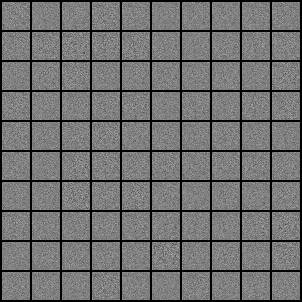

In [31]:
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))